# Notebook 21 #

In this notebook, the model for steel prediction was trained. The dataset contained several different noises - all without the images generated using fourier noise. The purpose of such experiment was to check whether the Fourier noise introduced the bias in the model to predict only values on edges (either 0.0 - 0.2 or 0.8 - 1.0).

In [21]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

import numpy as np
import pandas as pd

from PIL import Image

from sklearn.model_selection import train_test_split

In [22]:
class ImageDataset(Dataset):
    def __init__(self, path: str, parameters: pd.DataFrame, transform=None) -> None:
        self.image_paths = np.array([path + filename for filename in parameters['filename'].to_numpy()])
        self.labels = parameters['epsilon'].to_numpy()
        self.transform = transform

    def __getitem__(self, inx):
        image_path = self.image_paths[inx]
        label_float_epsilon = self.labels[inx]
        target = np.zeros(shape=(1000,))
        target[int(label_float_epsilon*1000)] = 1
        image = Image.open(image_path)
        image = np.array(image)
        # repeat grayscale value three times for all RGB channels
        image = np.repeat(image[..., np.newaxis], 3, -1)
        if self.transform:
            image = self.transform(image)
        return image, torch.from_numpy(target)

    def __len__(self):
        return len(self.image_paths)

In [23]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [24]:
# read csv with steel images
all_steel_df = pd.read_csv("../data/generated/all/steel/parameters.csv", index_col=False)
avg_steel_df = pd.read_csv("../data/generated/average/steel/parameters.csv", index_col=False)

# add prefix "all/steel/" to the filename column
all_steel_df['filename'] = "all/steel/" + all_steel_df['filename'].astype(str)
# the same for the average dataframe
avg_steel_df['filename'] = "average/steel/" + avg_steel_df['filename'].astype(str)

In [26]:
main_dir = "../data/generated/"

In [27]:
all_steel_train, all_steel_test = train_test_split(all_steel_df, test_size=0.4, random_state=12, shuffle=True, stratify=all_steel_df['epsilon'])
all_steel_test, all_steel_valid = train_test_split(all_steel_test, test_size=1000, random_state=12, shuffle=True, stratify=all_steel_test['epsilon'])
avg_steel_train, avg_steel_test = train_test_split(avg_steel_df, test_size=0.4, random_state=12, shuffle=True, stratify=avg_steel_df['epsilon'])
avg_steel_test, avg_steel_valid = train_test_split(avg_steel_test, test_size=1000, random_state=12, shuffle=True, stratify=avg_steel_test['epsilon'])



In [29]:
main_params_dir = "../data/generated/"
blackbox_csv = pd.read_csv(main_params_dir+"blackbox_train.csv", index_col=False)
blackbox_csv["filename"] = "blackbox/" + blackbox_csv["filename"].astype(str)
blackbox_train, blackbox_valid = train_test_split(blackbox_csv, test_size=1000, random_state=12, shuffle=True, stratify=blackbox_csv['epsilon'])

bubble_csv = pd.read_csv(main_params_dir+"bubble_train.csv", index_col=False)
bubble_csv["filename"] = "bubble/" + bubble_csv["filename"].astype(str)
bubble_train, bubble_valid = train_test_split(bubble_csv, test_size=1000, random_state=12, shuffle=True, stratify=bubble_csv['epsilon'])

pizza_csv = pd.read_csv(main_params_dir+"pizza_train.csv", index_col=False)
pizza_csv["filename"] = "pizza/" + pizza_csv["filename"].astype(str)
pizza_train, pizza_valid = train_test_split(pizza_csv, test_size=1000, random_state=12, shuffle=True, stratify=pizza_csv['epsilon'])

pure_csv = pd.read_csv(main_params_dir+"pure_train.csv", index_col=False)
pure_csv["filename"] = "pure/" + pure_csv["filename"].astype(str)
pure_train, pure_valid = train_test_split(pure_csv, test_size=1000, random_state=12, shuffle=True, stratify=pure_csv['epsilon'])


# laod test csv
blackbox_test = pd.read_csv(main_params_dir+"blackbox_test.csv", index_col=False)
blackbox_test["filename"] = "blackbox/" + blackbox_test["filename"].astype(str)

bubble_test = pd.read_csv(main_params_dir+"bubble_test.csv", index_col=False)
bubble_test["filename"] = "bubble/" + bubble_test["filename"].astype(str)

pizza_test = pd.read_csv(main_params_dir+"pizza_test.csv", index_col=False)
pizza_test["filename"] = "pizza/" + pizza_test["filename"].astype(str)

pure_test = pd.read_csv(main_params_dir+"pure_test.csv", index_col=False)
pure_test["filename"] = "pure/" + pure_test["filename"].astype(str)

In [30]:
DATASETS = {
    "all": {
        "train": all_steel_train,
        "valid": all_steel_valid,
        "test": all_steel_test
    },
    "average": {
        "train": avg_steel_train,
        "valid": avg_steel_valid,
        "test": avg_steel_test
    },
    "blackbox": {
        "train": blackbox_train,
        "valid": blackbox_valid,
        "test": blackbox_test
    },
    "bubble": {
        "train": bubble_train,
        "valid": bubble_valid,
        "test": bubble_test
    },
    "pizza": {
        "train": pizza_train,
        "valid": pizza_valid,
        "test": pizza_test
    },
    "pure": {
        "train": pure_train,
        "valid": pure_valid,
        "test": pure_test
    },
}

In [31]:
# combine all datasets
best_train = pd.concat([DATASETS["pure"]["train"], 
                        DATASETS["average"]["train"],
                        DATASETS["all"]["train"],
                        DATASETS["blackbox"]["train"],
                        DATASETS["bubble"]["train"],
                        DATASETS["pizza"]["train"]]).sample(frac=1, random_state=12).reset_index(drop=True)

best_valid = pd.concat([DATASETS["pure"]["valid"], 
                        DATASETS["average"]["valid"],
                        DATASETS["all"]["valid"],
                        DATASETS["blackbox"]["valid"],
                        DATASETS["bubble"]["valid"],
                        DATASETS["pizza"]["valid"]]).sample(frac=1, random_state=12).reset_index(drop=True)

In [32]:
train_dataset = ImageDataset(path=main_dir,
                             parameters=best_train,
                             transform=transform)
valid_dataset = ImageDataset(path=main_dir,
                             parameters=best_valid,
                             transform=transform)

In [33]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True, num_workers=0)

In [34]:
import torch.nn as nn
from torchvision import models
import torch.optim as optim
from tqdm import tqdm

In [35]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
lr = 1e-4
epochs = 10
print(device)

cuda


In [36]:
def cyclic_MAE(outputs, targets):
    x1 = torch.minimum(torch.abs(outputs-targets), torch.minimum(torch.abs(outputs-targets+1), torch.abs(outputs-targets-1)))
    return torch.mean(x1)

In [37]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [38]:
model = models.resnet18(pretrained=True)

classifier = nn.Sequential(
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.ReLU(),
    nn.Linear(512, 1000)
)

model.fc = classifier

c:\Users\janko\OneDrive\Pulpit\Artificial intelligence\Magisterka\topography-public\venv_torch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\janko\OneDrive\Pulpit\Artificial intelligence\Magisterka\topography-public\venv_torch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [39]:
optimizer = torch.optim.AdamW(params =  model.parameters(), lr=lr, eps=1e-8)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1, factor=0.9, min_lr=1e-5)

In [40]:
min_valid_loss = np.inf
history = {'train_losses': [], 'valid_losses': []}

model.cuda()

for epoch in range(epochs):
    model.train()
    train_batch_losses = []
    for data, labels in tqdm(train_loader):
        images = data.cuda()
        targets = labels.cuda()
        outputs = model(images)
        
        loss = loss_fn(outputs, targets)

        #optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_batch_losses.append(loss.item())
    train_loss = np.sum(train_batch_losses) / len(train_batch_losses)
    history['train_losses'].append(train_loss)

    model.eval()
    fin_targets=[]
    fin_outputs=[]
    valid_batch_losses=[]
    with torch.no_grad():
        for data, labels in valid_loader:
            images = data.cuda()
            targets = labels.cuda()
            outputs = model(images)

            loss = loss_fn(outputs, targets)
            valid_batch_losses.append(loss.item())
        valid_loss = np.sum(valid_batch_losses) / len(valid_batch_losses)
        history['valid_losses'].append(valid_loss)
    
    if min_valid_loss > valid_loss:
        torch.save(model.state_dict(), '../models/21_notebook/best_steel_model.pth')
        min_valid_loss = valid_loss
    
    print(f'Epoch {epoch} \t\t Training Loss: {train_loss} \t\t Validation Loss: {valid_loss}')
    scheduler.step(valid_loss)


    torch.save(model.state_dict(), '../models/21_notebook/final_steel_model.pth')

100%|██████████| 1125/1125 [04:23<00:00,  4.28it/s]


Epoch 0 		 Training Loss: 0.023160892197720266 		 Validation Loss: 0.007986839708676991


100%|██████████| 1125/1125 [04:01<00:00,  4.66it/s]


Epoch 1 		 Training Loss: 0.008118502819264047 		 Validation Loss: 0.006888945340002451


100%|██████████| 1125/1125 [04:09<00:00,  4.51it/s]


Epoch 2 		 Training Loss: 0.006514634950947354 		 Validation Loss: 0.005557103389988484


100%|██████████| 1125/1125 [04:02<00:00,  4.64it/s]


Epoch 3 		 Training Loss: 0.005680273735344872 		 Validation Loss: 0.005048221856304497


100%|██████████| 1125/1125 [04:01<00:00,  4.66it/s]


Epoch 4 		 Training Loss: 0.005209516904419539 		 Validation Loss: 0.004684298512738761


100%|██████████| 1125/1125 [04:02<00:00,  4.64it/s]


Epoch 5 		 Training Loss: 0.0048756823043077544 		 Validation Loss: 0.004440145648634688


100%|██████████| 1125/1125 [04:01<00:00,  4.66it/s]


Epoch 6 		 Training Loss: 0.004616912858835935 		 Validation Loss: 0.004229661386381126


100%|██████████| 1125/1125 [03:59<00:00,  4.69it/s]


Epoch 7 		 Training Loss: 0.004399638849596895 		 Validation Loss: 0.004095500519721032


100%|██████████| 1125/1125 [04:03<00:00,  4.62it/s]


Epoch 8 		 Training Loss: 0.004217337451726962 		 Validation Loss: 0.003921321369782558


100%|██████████| 1125/1125 [04:02<00:00,  4.65it/s]


Epoch 9 		 Training Loss: 0.00406202830683946 		 Validation Loss: 0.003825810607248129


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import models
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

from PIL import Image

from captum.attr import IntegratedGradients
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

c:\Users\janko\OneDrive\Pulpit\Artificial intelligence\Magisterka\topography-public\venv_torch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
steel = pd.read_csv('../data/results/21_notebook/best_steel_model.csv')

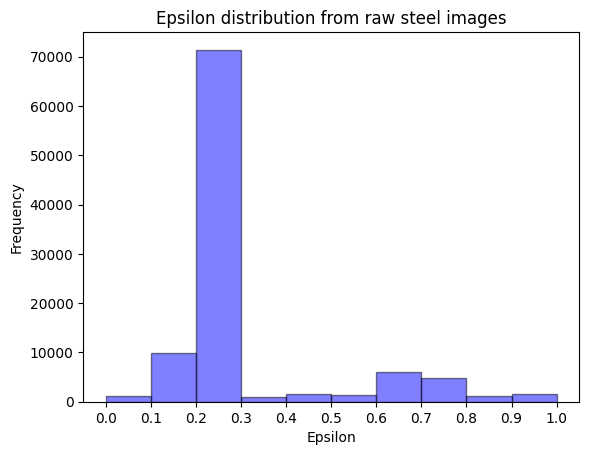

In [6]:
plt.hist(steel['epsilon'], bins=10, range=(0, 1), color='blue', alpha=0.5, edgecolor='black')
plt.title('Epsilon distribution from raw steel images')
plt.xlabel('Epsilon')
plt.ylabel('Frequency')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.show()

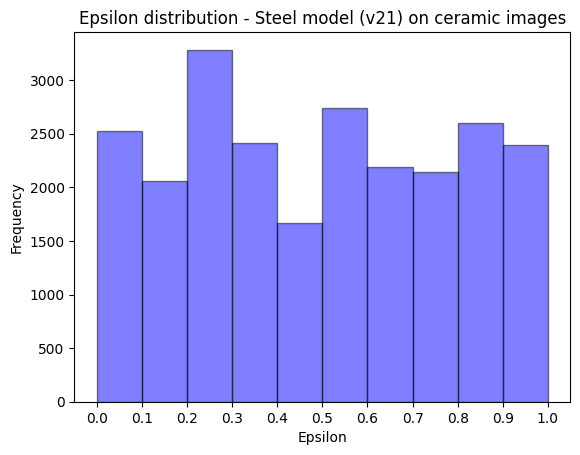

In [2]:
ceramic = pd.read_csv('../data/results/21_notebook/best_steel_model_4_ceramic.csv')

plt.hist(ceramic['epsilon'], bins=10, range=(0, 1), color='blue', alpha=0.5, edgecolor='black')
plt.title('Epsilon distribution - Steel model (v21) on ceramic images')
plt.xlabel('Epsilon')
plt.ylabel('Frequency')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.show()

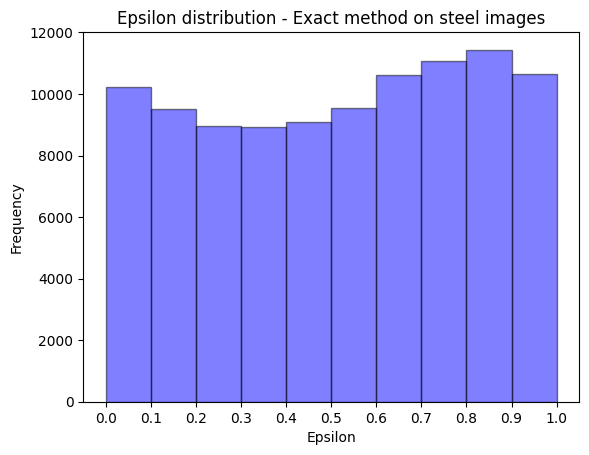

In [3]:
ceramic = pd.read_csv('../data/results/exact_method/exact_method-raw_steel_predictions.csv')

plt.hist(ceramic['epsilon'], bins=10, range=(0, 1), color='blue', alpha=0.5, edgecolor='black')
plt.title('Epsilon distribution - Exact method on steel images')
plt.xlabel('Epsilon')
plt.ylabel('Frequency')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.show()

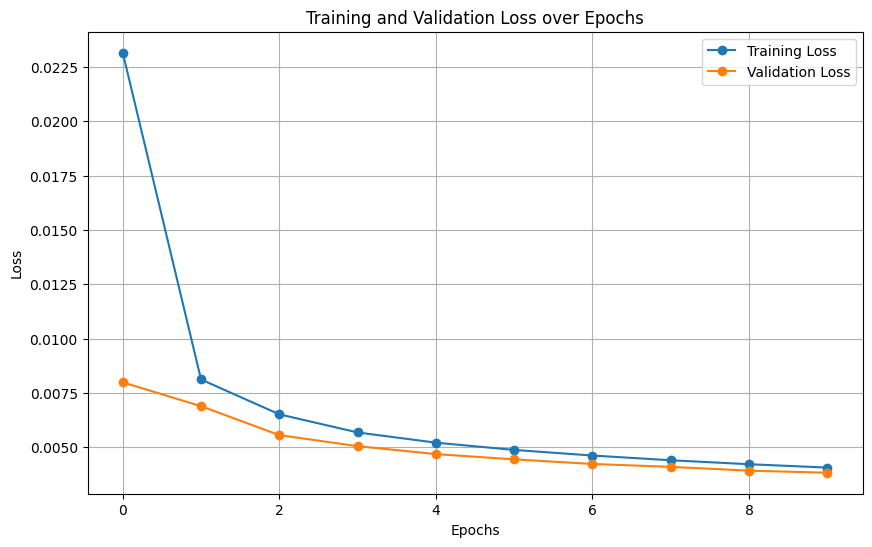

In [7]:
import matplotlib.pyplot as plt

# Extracted data from the logs
epochs = list(range(10))
training_loss = [
    0.023160892197720266,
    0.008118502819264047,
    0.006514634950947354,
    0.005680273735344872,
    0.005209516904419539,
    0.0048756823043077544,
    0.004616912858835935,
    0.004399638849596895,
    0.004217337451726962,
    0.00406202830683946
]

validation_loss = [
    0.007986839708676991,
    0.006888945340002451,
    0.005557103389988484,
    0.005048221856304497,
    0.004684298512738761,
    0.004440145648634688,
    0.004229661386381126,
    0.004095500519721032,
    0.003921321369782558,
    0.003825810607248129
]

# Plotting the loss curves
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()